In [19]:
# Import the libraries
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import rasterio as rio

import matplotlib.pyplot as plt
import argparse

import numpy as np

## Load Image
We are going to load an image in using rasterio so that we can get the source metadata and then transform it to be in a format for Scikit-Image.

In [2]:
image_file = r"C:\Users\RQ\Documents\PCA\South_Block_mosaic_RGB_1m.tif"
sat_data = rio.open(image_file)

## Image Analysis
Let's take a look at some of the properties of our image.

### Bands

In [3]:
print('Bands: {}'.format(sat_data.count))

# Sequence of band indexes
print(sat_data.indexes)

Bands: 3
(1, 2, 3)


In [4]:
# Get the metadata
src_meta = sat_data.meta

src_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 2317,
 'height': 2001,
 'count': 3,
 'crs': CRS.from_dict(init='epsg:26915'),
 'transform': Affine(1.0, 0.0, 446335.0,
        0.0, -1.0, 5641349.0)}

In [5]:
# Get important information from metadata
n_bands = src_meta['count']
height = src_meta['height']
width = src_meta['width']

n_bands, height, width

(3, 2001, 2317)

### Read in Image

In [6]:
# Read all the bands in for the image
img = img_as_float(sat_data.read())

In [7]:
img.shape

(3, 2001, 2317)

This means there are 3 bands, the height is 2001 and the width is 2317. Image is read in as (n_bands, height, width) so we transform it to (height, width, n_bands).

In [8]:
# Transform image to (height, width, n_bands)
new_image = np.moveaxis(img, 0, -1) 

In [9]:
# Let's see our array
new_image

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

## Preprocessing
We can see that we have a lot of 0's in the beginning and end of our array. These indicate no data, so areas where there is no image (e.g. black space). We want to see if this impacts our SLIC so we will first try it out without removing the 0s and then with removing the 0s. 

In [10]:
new_image.shape

(2001, 2317, 3)

In [11]:
# Mask all NaNs
mask = new_image != 0 
notnull_array = new_image[mask]
notnull_array = notnull_array.reshape(-1, n_bands)

notnull_array.shape

(4544498, 3)

In [12]:
# Create empty array to store the results
results = np.zeros(new_image.shape)

results

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

## SLIC Process
We are going to try this process out with 250 segments.

So we will compare the final results of SLIC on notnull_array once it is placed back into the results array and the new_image array to see what the difference is.

### Part One
<li> Only with non-null arrays

In [13]:
segments = slic(notnull_array, n_segments=250, compactness=5, sigma=1)
bounds = mark_boundaries(notnull_array, segments)

In [14]:
# Reshape our segments2 back 
segments = segments.reshape(-1,)

# Change the results values
results[mask] = segments

# Reshape results so rasterio can export it 
results = np.moveaxis(results, -1, 0)

# Check shape 
results.shape

(3, 2001, 2317)

In [15]:
results

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

#### Exporting the Segments Image

In [16]:
# Make a copy of the metadata
dst_meta = src_meta.copy()

dst_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 2317,
 'height': 2001,
 'count': 3,
 'crs': CRS.from_dict(init='epsg:26915'),
 'transform': Affine(1.0, 0.0, 446335.0,
        0.0, -1.0, 5641349.0)}

We need to change the dtype and then export the image out with this metadata.

In [17]:
# Change dtype
dst_meta['dtype'] = str(results.dtype)

In [18]:
# Open a new file in 'write' mode and unpack (**) the destination metadata
dst_fp = r"C:\Users\RQ\Documents\PCA\segments_nonNulls.tif"
with rio.open(dst_fp, 'w', **dst_meta) as dst:
    dst.write(results)

### Part Two
<li> Without removing null values (zeros in the array)

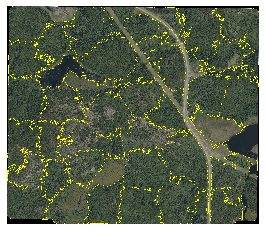

In [24]:
segments2 = slic(new_image, n_segments=n_segments, compactness=10, sigma=1)
    
# Show the output of SLIC 
fig = plt.figure("Superpixels")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(new_image, segments2))
plt.axis("off")
    
plt.show()

#### Exporting the Segments Image

In [11]:
# Shape of segments
segments2.shape

(2001, 2317)

In [12]:
# Add a new dimension
final_segments = segments2[:, :, np.newaxis]

# Reshape to be n_bands, height, width
final_segments = np.moveaxis(final_segments, -1, 0)

final_segments.shape

(1, 2001, 2317)

In [13]:
# View our segments
final_segments = final_segments.astype('int32')

final_segments

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [37, 37, 37, ..., 33, 33, 33],
        [37, 37, 37, ..., 33, 33, 33],
        [37, 37, 37, ..., 33, 33, 33]]])

#### Destination Metadata

In [14]:
dst_meta2 = src_meta.copy()

dst_meta2

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 2317,
 'height': 2001,
 'count': 3,
 'crs': CRS.from_dict(init='epsg:26915'),
 'transform': Affine(1.0, 0.0, 446335.0,
        0.0, -1.0, 5641349.0)}

Notice that nodata is already set to 0, and the height and width are the same. All we have to do is change the number of bands from 3 to 1.

In [15]:
# Change the number of bands
dst_meta2['count'] = 1 

# Change the dtype
dst_meta2['dtype'] = str(final_segments.dtype)

In [16]:
dst_meta2

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': 0.0,
 'width': 2317,
 'height': 2001,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:26915'),
 'transform': Affine(1.0, 0.0, 446335.0,
        0.0, -1.0, 5641349.0)}

In [17]:
dst_fp = r"C:\Users\RQ\Documents\PCA\segments_full_" + str(n_segments) + ".tif"

dst_fp

'C:\\Users\\RQ\\Documents\\PCA\\segments_full_60.tif'

In [18]:
# Open a new file in 'write' mode and unpack (**) the destination metadata
with rio.open(dst_fp, 'w', **dst_meta2) as dst:
    dst.write(final_segments)